# StreetViewGAN - Translating Between Maps and Real World Images

In [1]:
import os, random, pathlib, tarfile, urllib.request
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms
from torchvision.transforms import InterpolationMode, functional as TF
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image
from PIL import Image as PILImage
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import gradio as gr

# # For reproducibility
# random.seed(42)
# np.random.seed(42)
# torch.manual_seed(42)

%matplotlib inline

C:\Users\NYUAD\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download the Dataset

In [2]:
# dataset_name = "maps"
# _URL = f"http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz"

# # Download and extract the dataset
# def download_and_extract(url, download_path):
#     if not download_path.exists():
#         print(f"Downloading {url}...")
#         tar_path, _ = urllib.request.urlretrieve(url)
#         print(f"Extracting to {download_path}...")
#         with tarfile.open(tar_path, "r:gz") as tar:
#             tar.extractall(path=download_path.parent)
#     else:
#         print(f"{dataset_name} already downloaded.")

# # Set paths
# base_path = pathlib.Path('./data')
# download_path = base_path / dataset_name
# base_path.mkdir(exist_ok=True)

# download_and_extract(_URL, download_path)

# # Now dataset is available at:
# print("Dataset path:", download_path)

## Data Preprocessing

In [3]:
full_transform = transforms.Compose([
    transforms.Resize((256, 512), interpolation=InterpolationMode.BICUBIC),
    transforms.CenterCrop((256, 512)),           
    transforms.RandomVerticalFlip(p=0.5),          
])

to_tensor_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])


In [4]:
class Pix2PixDataset(Dataset):
    def __init__(self, root_dir, mode='train', full_transform=None, to_tensor=None):
        self.files = sorted((pathlib.Path(root_dir)/mode).glob("*.jpg"))
        self.full_transform = full_transform
        self.to_tensor      = to_tensor

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = PILImage.open(self.files[idx]).convert("RGB")   
        if self.full_transform:
            img = self.full_transform(img)                  

        w, h = img.size 
        w2   = w // 2

        street_pil = img.crop((0,    0, w2, h))  # left half
        map_pil    = img.crop((w2,   0,  w, h))  # right half

        if self.to_tensor:
            street = self.to_tensor(street_pil)  # Tensor [3×256×256]
            map_   = self.to_tensor(map_pil)     # Tensor [3×256×256]
        else:
            street, map_ = street_pil, map_pil

        return street, map_

In [5]:
bs = 1
data_dir = "./data/maps"

train_ds = Pix2PixDataset(data_dir, mode='train',
                          full_transform=full_transform,
                          to_tensor=to_tensor_norm)

train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True,  num_workers=0)

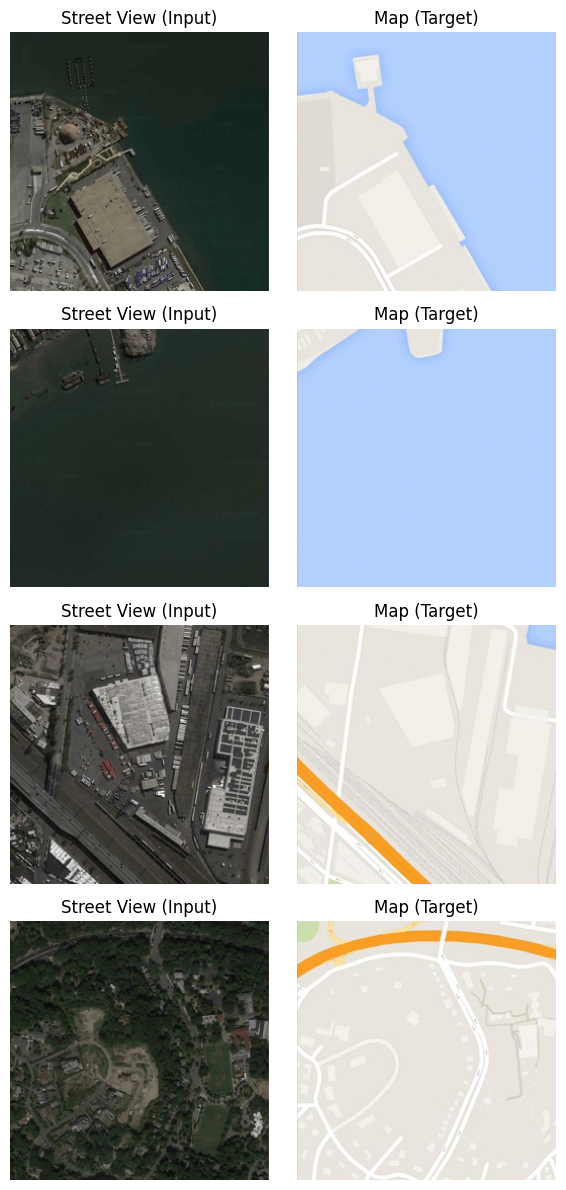

In [6]:
fig, axes = plt.subplots(4, 2, figsize=(6, 12))
for i, (street, map_) in enumerate(train_dl):
    if i == 4: break

    inp = street * 0.5 + 0.5
    tgt = map_ * 0.5 + 0.5

    axes[i,0].imshow(inp[0].permute(1,2,0))
    axes[i,0].set_title("Street View (Input)")
    axes[i,1].imshow(tgt[0].permute(1,2,0))
    axes[i,1].set_title("Map (Target)")
    for ax in axes[i]:
        ax.axis("off")

plt.tight_layout()
plt.show()

## Discriminator Network

In [7]:
class Pix2PixDiscriminator(nn.Module):
    def __init__(self, in_channels=3, base_features=64):
        super().__init__()
        # Since we concatenate two images, the first conv sees in_channels*2
        self.model = nn.Sequential(
        # → (in_channels*2) x 256 x 256
        nn.Conv2d(in_channels * 2, base_features, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        # → base_features x 128 x 128

        nn.Conv2d(base_features, base_features*2, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(base_features*2),
        nn.LeakyReLU(0.2, inplace=True),
        # → (base_features*2) x 64 x 64

        nn.Conv2d(base_features*2, base_features*4, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(base_features*4),
        nn.LeakyReLU(0.2, inplace=True),
        # → (base_features*4) x 32 x 32

        nn.ZeroPad2d(1),  
        # → (base_features*4) x 34 x 34

        nn.Conv2d(base_features*4, base_features*8, kernel_size=4, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(base_features*8),
        nn.LeakyReLU(0.2, inplace=True),
        # → (base_features*8) x 32 x 32

        # final “patch” conv; produces a 31×31 score map
        nn.Conv2d(base_features*8, 1, kernel_size=4, stride=1, padding=1, bias=False),
        # → 1 x 31 x 31
        nn.Sigmoid(),
        )

    def forward(self, real_input, real_target):
        x = torch.cat([real_input, real_target], dim = 1)  
        return self.model(x)

## Generator Network

In [8]:
class Pix2PixGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=64):
        super().__init__()
        # --- ENCODER (downsampling) ---
        # 256→128
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=4, stride=2, padding=1, bias=False),
        )

        # 128→64
        self.enc2 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(features, features * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features * 2)
        )
        # 64→32
        self.enc3 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(features * 2, features * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features * 4)
        )
        # 32→16
        self.enc4 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(features * 4, features * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features * 8)
        )
        # 16→8
        self.enc5 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(features * 8, features * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features * 8)
        )
        # 8→4
        self.enc6 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(features * 8, features * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features * 8)
        )
        # 4→2
        self.enc7 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(features * 8, features * 8, kernel_size=4, stride=2, padding=1, bias=False)
        )

        # --- DECODER (upsampling) ---
        # 1→2
        self.dec1 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(features * 8, features * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features * 8),
            nn.Dropout(0.5)
        )
        # 2→4 (cat → 16 channels in)
        self.dec2 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(features * 8 * 2, features * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features * 8),
            nn.Dropout(0.5)
        )
        # 4→8
        self.dec3 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(features * 8 * 2, features * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features * 8),
            nn.Dropout(0.5)
        )
        # 8→16
        self.dec4 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(features * 8 * 2, features * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features * 4)
        )
        # 16→32 (cat 16+16→32 channels)
        self.dec5 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(features * 4 * 2, features * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features * 2)
        )
        # 32→64
        self.dec6 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(features * 2 * 2, features, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features)
        )
        # 64→128
        self.dec7 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(features * 2, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        e5 = self.enc5(e4)
        e6 = self.enc6(e5)
        e7 = self.enc7(e6)

        d1 = torch.cat([self.dec1(e7), e6], dim=1)
        d2 = torch.cat([self.dec2(d1), e5], dim=1)
        d3 = torch.cat([self.dec3(d2), e4], dim=1)
        d4 = torch.cat([self.dec4(d3), e3], dim=1)
        d5 = torch.cat([self.dec5(d4), e2], dim=1)
        d6 = torch.cat([self.dec6(d5), e1], dim=1)

        return self.dec7(d6)

## Discriminator Training

In [9]:
def train_discriminator(discriminator, generator, real_images, map_images, opt_d):
    discriminator.train()
    
    # Clear discriminator gradients
    opt_d.zero_grad()

    # ——— Real pairs ———
    # D(map, real) should predict “real” → target=1
    real_preds = discriminator(real_images, map_images)
    real_targets = torch.ones_like(real_preds)
    real_loss = 0.5 * F.binary_cross_entropy(real_preds, real_targets)
    real_score = real_preds.mean().item()

    # ——— Fake pairs ———
    # Generate fake images
    # G(map) → fake; detach so G’s grad isn’t updated here
    fake_images = generator(real_images).detach()
    fake_preds = discriminator(real_images, fake_images)
    fake_targets = torch.zeros_like(fake_preds)
    fake_loss    = 0.5 * F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score   = fake_preds.mean().item()


    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    
    return loss.item(), real_score, fake_score

## Generator Training

In [10]:
def train_generator(discriminator, generator, real_images, map_images, opt_g, lambda_L1 = 100):
    generator.train()

    loss_total = 0.0
    adv_total = 0.0
    l1_total = 0.0

    # Train G twice per D step
    for _ in range(2):  
        # Clear generator gradients                                     
        opt_g.zero_grad()

        # 1) Adversarial loss
        # Generate fake images
        fake_images = generator(real_images)

        # Try to fool the discriminator
        preds = discriminator(real_images, fake_images)
        targets = torch.ones_like(preds)
        adv_loss = F.binary_cross_entropy(preds, targets)

        # 2) L1 reconstruction loss
        l1_loss  = F.l1_loss(fake_images, map_images, reduction="mean")

        total_loss = adv_loss + (lambda_L1 * l1_loss)

        total_loss.backward()
        opt_g.step()

        loss_total += total_loss.item()
        adv_total   += adv_loss.item()
        l1_total    += l1_loss.item()

    # Average over the two updates
    return loss_total / 2, adv_total / 2, l1_total / 2

In [11]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

## Saving Generated Samples

In [12]:
def save_samples(idx, street_batch, generator, denorm, show=False):
    generator.eval()
    with torch.no_grad():
        fake = generator(street_batch)         

    # Denormalize into [0,1] for saving/viewing
    fake = denorm(fake)

    fname = f'generated-images-{idx:04d}.png'
    save_image(fake, os.path.join(sample_dir, fname), nrow=8)
    print('Saving', fname)

    if show:
        grid = make_grid(fake.cpu(), nrow=8)   # shape (3, H, W)
        plt.figure(figsize=(8,8))
        plt.axis('off')
        plt.imshow(grid.permute(1,2,0)) # H×W×3
        plt.show()

## Full Training Loop

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
# Denormalize from [-1,1] back to [0,1]
def denorm(imgs):
    return imgs * 0.5 + 0.5

In [15]:
def init_weights(m):
    if hasattr(m, "weight") and m.weight is not None:
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.normal_(m.weight, 0.0, 0.02)
        elif isinstance(m, (nn.BatchNorm2d, nn.InstanceNorm2d)):
            nn.init.normal_(m.weight, 1.0, 0.02)
    if hasattr(m, "bias") and m.bias is not None:
        nn.init.constant_(m.bias, 0)

In [16]:
def fit(
    discriminator: nn.Module,
    generator:     nn.Module,
    train_dl,
    fixed_streets,        # a batch of streets images, e.g. next(iter(val_dl))
    denorm,               # function mapping [-1,1]→[0,1]
    device = None,
    epochs = 200,
    lr = 2e-4,
    start_idx = 1
):
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
   
    # ── LR schedulers: decay LR by 0.5 every 25 epochs ──
    sched_d = torch.optim.lr_scheduler.StepLR(opt_d, step_size=25, gamma=0.5)
    sched_g = torch.optim.lr_scheduler.StepLR(opt_g, step_size=25, gamma=0.5)

    for epoch in range(start_idx, start_idx + epochs):
        sum_d = sum_g = 0.0
        sum_real_s = sum_fake_s = 0.0
        n = 0

        for street_imgs, map_imgs in tqdm(train_dl, desc=f"Epoch {epoch}/{start_idx+epochs-1}"):
            # — Train D —
            d_loss, real_s, fake_s = train_discriminator(
                discriminator, generator,
                street_imgs, map_imgs,
                opt_d
            )

            # — Train G —
            g_loss, adv_loss, l1_loss = train_generator(
                discriminator, generator,
                street_imgs, map_imgs,
                opt_g
            )

            sum_d       += d_loss
            sum_g       += g_loss
            sum_real_s  += real_s
            sum_fake_s  += fake_s
            n           += 1

        # Averages
        avg_d = sum_d / n
        avg_g = sum_g / n
        avg_real = sum_real_s / n
        avg_fake = sum_fake_s / n

        # Record losses & scores
        losses_d.append(avg_d)
        losses_g.append(avg_g)
        real_scores.append(avg_real)
        fake_scores.append(avg_fake)

        # Log losses & scores (last batch)
        print(
            f"Epoch [{epoch}]  "
            f"loss_g: {avg_g:.4f}, loss_d: {avg_d:.4f}, "
            f"real_score: {avg_real:.4f}, fake_score: {avg_fake:.4f}"
        )

        # Save generated images
        save_samples(epoch, fixed_streets, generator, denorm)

        # Step the schedulers each epoch
        sched_d.step()
        sched_g.step()

        if epoch % 5 == 0:
            torch.save(generator.state_dict(), f"checkpoint_gen_epoch{epoch}.pth")

    return losses_g, losses_d, real_scores, fake_scores

In [17]:
discriminator = Pix2PixDiscriminator()
generator     = Pix2PixGenerator()

generator.apply(init_weights)
discriminator.apply(init_weights)

fixed_streets, _ = next(iter(train_dl))
lr = 0.0002
epochs = 200

history = fit(
    discriminator=discriminator,
    generator=generator,
    train_dl=train_dl,
    fixed_streets=fixed_streets,
    denorm=denorm,
    device=device,  
    epochs=epochs,
    lr=lr,
    start_idx=1
)

losses_g, losses_d, real_scores, fake_scores = history

Epoch 1/200: 100%|██████████| 1096/1096 [18:46<00:00,  1.03s/it]


Epoch [1]  loss_g: 12.6918, loss_d: 0.4952, real_score: 0.6733, fake_score: 0.3265
Saving generated-images-0001.png


Epoch 2/200: 100%|██████████| 1096/1096 [17:58<00:00,  1.02it/s]


Epoch [2]  loss_g: 10.7437, loss_d: 0.4845, real_score: 0.6794, fake_score: 0.3178
Saving generated-images-0002.png


Epoch 3/200: 100%|██████████| 1096/1096 [17:42<00:00,  1.03it/s]


Epoch [3]  loss_g: 9.6266, loss_d: 0.4956, real_score: 0.6696, fake_score: 0.3287
Saving generated-images-0003.png


Epoch 4/200: 100%|██████████| 1096/1096 [17:18<00:00,  1.06it/s]


Epoch [4]  loss_g: 8.9851, loss_d: 0.4894, real_score: 0.6711, fake_score: 0.3243
Saving generated-images-0004.png


Epoch 5/200: 100%|██████████| 1096/1096 [17:52<00:00,  1.02it/s]


Epoch [5]  loss_g: 8.7032, loss_d: 0.4625, real_score: 0.6889, fake_score: 0.3087
Saving generated-images-0005.png


Epoch 6/200: 100%|██████████| 1096/1096 [18:01<00:00,  1.01it/s]


Epoch [6]  loss_g: 8.5624, loss_d: 0.4477, real_score: 0.7027, fake_score: 0.2952
Saving generated-images-0006.png


Epoch 7/200: 100%|██████████| 1096/1096 [17:39<00:00,  1.03it/s]


Epoch [7]  loss_g: 8.4741, loss_d: 0.4166, real_score: 0.7233, fake_score: 0.2759
Saving generated-images-0007.png


Epoch 8/200: 100%|██████████| 1096/1096 [17:45<00:00,  1.03it/s]


Epoch [8]  loss_g: 8.4340, loss_d: 0.3830, real_score: 0.7434, fake_score: 0.2552
Saving generated-images-0008.png


Epoch 9/200: 100%|██████████| 1096/1096 [16:22<00:00,  1.11it/s]


Epoch [9]  loss_g: 8.4331, loss_d: 0.3617, real_score: 0.7615, fake_score: 0.2369
Saving generated-images-0009.png


Epoch 10/200: 100%|██████████| 1096/1096 [16:16<00:00,  1.12it/s]


Epoch [10]  loss_g: 8.5203, loss_d: 0.3279, real_score: 0.7815, fake_score: 0.2174
Saving generated-images-0010.png


Epoch 11/200: 100%|██████████| 1096/1096 [16:38<00:00,  1.10it/s]


Epoch [11]  loss_g: 8.4897, loss_d: 0.3099, real_score: 0.7964, fake_score: 0.2021
Saving generated-images-0011.png


Epoch 12/200: 100%|██████████| 1096/1096 [16:37<00:00,  1.10it/s]


Epoch [12]  loss_g: 8.5177, loss_d: 0.3003, real_score: 0.8036, fake_score: 0.1958
Saving generated-images-0012.png


Epoch 13/200: 100%|██████████| 1096/1096 [16:37<00:00,  1.10it/s]


Epoch [13]  loss_g: 8.4461, loss_d: 0.2919, real_score: 0.8089, fake_score: 0.1894
Saving generated-images-0013.png


Epoch 14/200: 100%|██████████| 1096/1096 [17:33<00:00,  1.04it/s]


Epoch [14]  loss_g: 8.4547, loss_d: 0.2740, real_score: 0.8220, fake_score: 0.1769
Saving generated-images-0014.png


Epoch 15/200: 100%|██████████| 1096/1096 [16:37<00:00,  1.10it/s]


Epoch [15]  loss_g: 8.4823, loss_d: 0.2523, real_score: 0.8348, fake_score: 0.1646
Saving generated-images-0015.png


Epoch 16/200: 100%|██████████| 1096/1096 [16:03<00:00,  1.14it/s]


Epoch [16]  loss_g: 8.4383, loss_d: 0.2633, real_score: 0.8289, fake_score: 0.1693
Saving generated-images-0016.png


Epoch 17/200: 100%|██████████| 1096/1096 [16:13<00:00,  1.13it/s]


Epoch [17]  loss_g: 8.2891, loss_d: 0.2795, real_score: 0.8266, fake_score: 0.1719
Saving generated-images-0017.png


Epoch 18/200: 100%|██████████| 1096/1096 [16:23<00:00,  1.11it/s]


Epoch [18]  loss_g: 8.3454, loss_d: 0.2622, real_score: 0.8368, fake_score: 0.1625
Saving generated-images-0018.png


Epoch 19/200: 100%|██████████| 1096/1096 [16:23<00:00,  1.11it/s]


Epoch [19]  loss_g: 8.1492, loss_d: 0.2601, real_score: 0.8340, fake_score: 0.1636
Saving generated-images-0019.png


Epoch 20/200: 100%|██████████| 1096/1096 [16:17<00:00,  1.12it/s]


Epoch [20]  loss_g: 8.3637, loss_d: 0.2188, real_score: 0.8589, fake_score: 0.1407
Saving generated-images-0020.png


Epoch 21/200: 100%|██████████| 1096/1096 [16:18<00:00,  1.12it/s]


Epoch [21]  loss_g: 8.2078, loss_d: 0.2575, real_score: 0.8404, fake_score: 0.1578
Saving generated-images-0021.png


Epoch 22/200: 100%|██████████| 1096/1096 [16:21<00:00,  1.12it/s]


Epoch [22]  loss_g: 8.3036, loss_d: 0.2366, real_score: 0.8469, fake_score: 0.1524
Saving generated-images-0022.png


Epoch 23/200: 100%|██████████| 1096/1096 [16:19<00:00,  1.12it/s]


Epoch [23]  loss_g: 8.1888, loss_d: 0.2478, real_score: 0.8446, fake_score: 0.1547
Saving generated-images-0023.png


Epoch 24/200: 100%|██████████| 1096/1096 [16:20<00:00,  1.12it/s]


Epoch [24]  loss_g: 8.1605, loss_d: 0.2509, real_score: 0.8432, fake_score: 0.1542
Saving generated-images-0024.png


Epoch 25/200: 100%|██████████| 1096/1096 [16:20<00:00,  1.12it/s]


Epoch [25]  loss_g: 8.1583, loss_d: 0.2338, real_score: 0.8526, fake_score: 0.1471
Saving generated-images-0025.png


Epoch 26/200: 100%|██████████| 1096/1096 [16:24<00:00,  1.11it/s]


Epoch [26]  loss_g: 8.1359, loss_d: 0.1285, real_score: 0.8988, fake_score: 0.1020
Saving generated-images-0026.png


Epoch 27/200: 100%|██████████| 1096/1096 [16:20<00:00,  1.12it/s]


Epoch [27]  loss_g: 8.1124, loss_d: 0.1958, real_score: 0.8681, fake_score: 0.1311
Saving generated-images-0027.png


Epoch 28/200: 100%|██████████| 1096/1096 [16:21<00:00,  1.12it/s]


Epoch [28]  loss_g: 8.0810, loss_d: 0.1635, real_score: 0.8839, fake_score: 0.1161
Saving generated-images-0028.png


Epoch 29/200: 100%|██████████| 1096/1096 [16:25<00:00,  1.11it/s]


Epoch [29]  loss_g: 8.1557, loss_d: 0.1754, real_score: 0.8775, fake_score: 0.1222
Saving generated-images-0029.png


Epoch 30/200: 100%|██████████| 1096/1096 [16:21<00:00,  1.12it/s]


Epoch [30]  loss_g: 8.1543, loss_d: 0.1740, real_score: 0.8798, fake_score: 0.1197
Saving generated-images-0030.png


Epoch 31/200: 100%|██████████| 1096/1096 [16:32<00:00,  1.10it/s]


Epoch [31]  loss_g: 8.1347, loss_d: 0.1949, real_score: 0.8736, fake_score: 0.1256
Saving generated-images-0031.png


Epoch 32/200: 100%|██████████| 1096/1096 [16:20<00:00,  1.12it/s]


Epoch [32]  loss_g: 8.1070, loss_d: 0.1638, real_score: 0.8831, fake_score: 0.1165
Saving generated-images-0032.png


Epoch 33/200: 100%|██████████| 1096/1096 [16:23<00:00,  1.11it/s]


Epoch [33]  loss_g: 8.1606, loss_d: 0.1653, real_score: 0.8857, fake_score: 0.1143
Saving generated-images-0033.png


Epoch 34/200: 100%|██████████| 1096/1096 [16:19<00:00,  1.12it/s]


Epoch [34]  loss_g: 7.9930, loss_d: 0.2187, real_score: 0.8612, fake_score: 0.1378
Saving generated-images-0034.png


Epoch 35/200: 100%|██████████| 1096/1096 [16:19<00:00,  1.12it/s]


Epoch [35]  loss_g: 8.2359, loss_d: 0.1527, real_score: 0.8899, fake_score: 0.1096
Saving generated-images-0035.png


Epoch 36/200: 100%|██████████| 1096/1096 [16:18<00:00,  1.12it/s]


Epoch [36]  loss_g: 8.0063, loss_d: 0.2202, real_score: 0.8642, fake_score: 0.1349
Saving generated-images-0036.png


Epoch 37/200: 100%|██████████| 1096/1096 [15:44<00:00,  1.16it/s]


Epoch [37]  loss_g: 8.0279, loss_d: 0.1872, real_score: 0.8719, fake_score: 0.1275
Saving generated-images-0037.png


Epoch 38/200: 100%|██████████| 1096/1096 [15:55<00:00,  1.15it/s]


Epoch [38]  loss_g: 8.0841, loss_d: 0.1783, real_score: 0.8790, fake_score: 0.1203
Saving generated-images-0038.png


Epoch 39/200: 100%|██████████| 1096/1096 [16:11<00:00,  1.13it/s]


Epoch [39]  loss_g: 8.1266, loss_d: 0.1757, real_score: 0.8798, fake_score: 0.1203
Saving generated-images-0039.png


Epoch 40/200: 100%|██████████| 1096/1096 [16:17<00:00,  1.12it/s]


Epoch [40]  loss_g: 8.0052, loss_d: 0.2137, real_score: 0.8668, fake_score: 0.1325
Saving generated-images-0040.png


Epoch 41/200: 100%|██████████| 1096/1096 [17:23<00:00,  1.05it/s]


Epoch [41]  loss_g: 8.0718, loss_d: 0.1659, real_score: 0.8849, fake_score: 0.1146
Saving generated-images-0041.png


Epoch 42/200: 100%|██████████| 1096/1096 [17:07<00:00,  1.07it/s]


Epoch [42]  loss_g: 7.9511, loss_d: 0.2350, real_score: 0.8569, fake_score: 0.1420
Saving generated-images-0042.png


Epoch 43/200: 100%|██████████| 1096/1096 [14:12<00:00,  1.29it/s]


Epoch [43]  loss_g: 7.9063, loss_d: 0.2049, real_score: 0.8658, fake_score: 0.1333
Saving generated-images-0043.png


Epoch 44/200: 100%|██████████| 1096/1096 [14:26<00:00,  1.27it/s]


Epoch [44]  loss_g: 8.0019, loss_d: 0.1805, real_score: 0.8841, fake_score: 0.1162
Saving generated-images-0044.png


Epoch 45/200: 100%|██████████| 1096/1096 [15:00<00:00,  1.22it/s]


Epoch [45]  loss_g: 7.8524, loss_d: 0.2135, real_score: 0.8623, fake_score: 0.1372
Saving generated-images-0045.png


Epoch 46/200: 100%|██████████| 1096/1096 [16:30<00:00,  1.11it/s]


Epoch [46]  loss_g: 7.9242, loss_d: 0.2044, real_score: 0.8675, fake_score: 0.1316
Saving generated-images-0046.png


Epoch 47/200: 100%|██████████| 1096/1096 [14:24<00:00,  1.27it/s]


Epoch [47]  loss_g: 7.9068, loss_d: 0.2007, real_score: 0.8690, fake_score: 0.1305
Saving generated-images-0047.png


Epoch 48/200: 100%|██████████| 1096/1096 [14:19<00:00,  1.28it/s]


Epoch [48]  loss_g: 7.8885, loss_d: 0.2012, real_score: 0.8686, fake_score: 0.1307
Saving generated-images-0048.png


Epoch 49/200: 100%|██████████| 1096/1096 [14:12<00:00,  1.29it/s]


Epoch [49]  loss_g: 7.8106, loss_d: 0.2200, real_score: 0.8603, fake_score: 0.1395
Saving generated-images-0049.png


Epoch 50/200: 100%|██████████| 1096/1096 [14:10<00:00,  1.29it/s]


Epoch [50]  loss_g: 7.9046, loss_d: 0.2005, real_score: 0.8683, fake_score: 0.1306
Saving generated-images-0050.png


Epoch 51/200: 100%|██████████| 1096/1096 [14:09<00:00,  1.29it/s]


Epoch [51]  loss_g: 7.8430, loss_d: 0.1386, real_score: 0.8939, fake_score: 0.1075
Saving generated-images-0051.png


Epoch 52/200: 100%|██████████| 1096/1096 [14:09<00:00,  1.29it/s]


Epoch [52]  loss_g: 7.8149, loss_d: 0.1543, real_score: 0.8843, fake_score: 0.1163
Saving generated-images-0052.png


Epoch 53/200: 100%|██████████| 1096/1096 [14:20<00:00,  1.27it/s]


Epoch [53]  loss_g: 7.8616, loss_d: 0.1549, real_score: 0.8855, fake_score: 0.1150
Saving generated-images-0053.png


Epoch 54/200: 100%|██████████| 1096/1096 [14:33<00:00,  1.25it/s]


Epoch [54]  loss_g: 7.8835, loss_d: 0.1499, real_score: 0.8873, fake_score: 0.1127
Saving generated-images-0054.png


Epoch 55/200: 100%|██████████| 1096/1096 [14:08<00:00,  1.29it/s]


Epoch [55]  loss_g: 7.8351, loss_d: 0.1676, real_score: 0.8791, fake_score: 0.1209
Saving generated-images-0055.png


Epoch 56/200: 100%|██████████| 1096/1096 [14:08<00:00,  1.29it/s]


Epoch [56]  loss_g: 7.8881, loss_d: 0.1478, real_score: 0.8901, fake_score: 0.1103
Saving generated-images-0056.png


Epoch 57/200: 100%|██████████| 1096/1096 [14:18<00:00,  1.28it/s]


Epoch [57]  loss_g: 7.9113, loss_d: 0.1446, real_score: 0.8904, fake_score: 0.1095
Saving generated-images-0057.png


Epoch 58/200: 100%|██████████| 1096/1096 [14:08<00:00,  1.29it/s]


Epoch [58]  loss_g: 7.9475, loss_d: 0.1483, real_score: 0.8896, fake_score: 0.1104
Saving generated-images-0058.png


Epoch 59/200: 100%|██████████| 1096/1096 [14:08<00:00,  1.29it/s]


Epoch [59]  loss_g: 7.9361, loss_d: 0.1566, real_score: 0.8867, fake_score: 0.1136
Saving generated-images-0059.png


Epoch 60/200: 100%|██████████| 1096/1096 [14:07<00:00,  1.29it/s]


Epoch [60]  loss_g: 7.9260, loss_d: 0.1635, real_score: 0.8829, fake_score: 0.1171
Saving generated-images-0060.png


Epoch 61/200: 100%|██████████| 1096/1096 [14:18<00:00,  1.28it/s]


Epoch [61]  loss_g: 7.9186, loss_d: 0.1602, real_score: 0.8843, fake_score: 0.1153
Saving generated-images-0061.png


Epoch 62/200: 100%|██████████| 1096/1096 [14:16<00:00,  1.28it/s]


Epoch [62]  loss_g: 7.9206, loss_d: 0.1630, real_score: 0.8830, fake_score: 0.1175
Saving generated-images-0062.png


Epoch 63/200: 100%|██████████| 1096/1096 [14:11<00:00,  1.29it/s]


Epoch [63]  loss_g: 7.9540, loss_d: 0.1478, real_score: 0.8899, fake_score: 0.1092
Saving generated-images-0063.png


Epoch 64/200: 100%|██████████| 1096/1096 [14:35<00:00,  1.25it/s]


Epoch [64]  loss_g: 7.9769, loss_d: 0.1428, real_score: 0.8930, fake_score: 0.1080
Saving generated-images-0064.png


Epoch 65/200: 100%|██████████| 1096/1096 [14:16<00:00,  1.28it/s]


Epoch [65]  loss_g: 7.9554, loss_d: 0.1693, real_score: 0.8798, fake_score: 0.1196
Saving generated-images-0065.png


Epoch 66/200: 100%|██████████| 1096/1096 [14:11<00:00,  1.29it/s]


Epoch [66]  loss_g: 7.9723, loss_d: 0.1451, real_score: 0.8918, fake_score: 0.1082
Saving generated-images-0066.png


Epoch 67/200: 100%|██████████| 1096/1096 [14:08<00:00,  1.29it/s]


Epoch [67]  loss_g: 7.9726, loss_d: 0.1601, real_score: 0.8865, fake_score: 0.1146
Saving generated-images-0067.png


Epoch 68/200: 100%|██████████| 1096/1096 [14:06<00:00,  1.29it/s]


Epoch [68]  loss_g: 7.9875, loss_d: 0.1548, real_score: 0.8874, fake_score: 0.1119
Saving generated-images-0068.png


Epoch 69/200: 100%|██████████| 1096/1096 [14:13<00:00,  1.28it/s]


Epoch [69]  loss_g: 7.9299, loss_d: 0.1730, real_score: 0.8822, fake_score: 0.1173
Saving generated-images-0069.png


Epoch 70/200: 100%|██████████| 1096/1096 [14:11<00:00,  1.29it/s]


Epoch [70]  loss_g: 8.0099, loss_d: 0.1513, real_score: 0.8912, fake_score: 0.1090
Saving generated-images-0070.png


Epoch 71/200: 100%|██████████| 1096/1096 [14:06<00:00,  1.29it/s]


Epoch [71]  loss_g: 8.0432, loss_d: 0.1445, real_score: 0.8936, fake_score: 0.1063
Saving generated-images-0071.png


Epoch 72/200: 100%|██████████| 1096/1096 [14:06<00:00,  1.30it/s]


Epoch [72]  loss_g: 8.0106, loss_d: 0.1681, real_score: 0.8830, fake_score: 0.1169
Saving generated-images-0072.png


Epoch 73/200: 100%|██████████| 1096/1096 [14:06<00:00,  1.29it/s]


Epoch [73]  loss_g: 7.9720, loss_d: 0.1788, real_score: 0.8791, fake_score: 0.1207
Saving generated-images-0073.png


Epoch 74/200: 100%|██████████| 1096/1096 [14:21<00:00,  1.27it/s]


Epoch [74]  loss_g: 7.9784, loss_d: 0.1521, real_score: 0.8896, fake_score: 0.1102
Saving generated-images-0074.png


Epoch 75/200: 100%|██████████| 1096/1096 [14:06<00:00,  1.30it/s]


Epoch [75]  loss_g: 8.0048, loss_d: 0.1628, real_score: 0.8858, fake_score: 0.1142
Saving generated-images-0075.png


Epoch 76/200: 100%|██████████| 1096/1096 [14:06<00:00,  1.29it/s]


Epoch [76]  loss_g: 7.9818, loss_d: 0.1139, real_score: 0.9076, fake_score: 0.0933
Saving generated-images-0076.png


Epoch 77/200: 100%|██████████| 1096/1096 [14:06<00:00,  1.29it/s]


Epoch [77]  loss_g: 7.9729, loss_d: 0.1245, real_score: 0.9020, fake_score: 0.0990
Saving generated-images-0077.png


Epoch 78/200: 100%|██████████| 1096/1096 [14:18<00:00,  1.28it/s]


Epoch [78]  loss_g: 7.9895, loss_d: 0.1216, real_score: 0.9028, fake_score: 0.0973
Saving generated-images-0078.png


Epoch 79/200: 100%|██████████| 1096/1096 [14:22<00:00,  1.27it/s]


Epoch [79]  loss_g: 8.0072, loss_d: 0.1290, real_score: 0.8998, fake_score: 0.1002
Saving generated-images-0079.png


Epoch 80/200: 100%|██████████| 1096/1096 [14:23<00:00,  1.27it/s]


Epoch [80]  loss_g: 8.0076, loss_d: 0.1161, real_score: 0.9063, fake_score: 0.0945
Saving generated-images-0080.png


Epoch 81/200: 100%|██████████| 1096/1096 [14:06<00:00,  1.29it/s]


Epoch [81]  loss_g: 8.0027, loss_d: 0.1310, real_score: 0.8996, fake_score: 0.1004
Saving generated-images-0081.png


Epoch 82/200: 100%|██████████| 1096/1096 [14:15<00:00,  1.28it/s]


Epoch [82]  loss_g: 8.1080, loss_d: 0.1140, real_score: 0.9083, fake_score: 0.0916
Saving generated-images-0082.png


Epoch 83/200: 100%|██████████| 1096/1096 [14:09<00:00,  1.29it/s]


Epoch [83]  loss_g: 8.0421, loss_d: 0.1228, real_score: 0.9045, fake_score: 0.0962
Saving generated-images-0083.png


Epoch 84/200: 100%|██████████| 1096/1096 [14:06<00:00,  1.29it/s]


Epoch [84]  loss_g: 8.0687, loss_d: 0.1148, real_score: 0.9080, fake_score: 0.0920
Saving generated-images-0084.png


Epoch 85/200: 100%|██████████| 1096/1096 [14:06<00:00,  1.30it/s]


Epoch [85]  loss_g: 8.0892, loss_d: 0.1197, real_score: 0.9067, fake_score: 0.0941
Saving generated-images-0085.png


Epoch 86/200: 100%|██████████| 1096/1096 [14:14<00:00,  1.28it/s]


Epoch [86]  loss_g: 8.1200, loss_d: 0.1194, real_score: 0.9069, fake_score: 0.0933
Saving generated-images-0086.png


Epoch 87/200: 100%|██████████| 1096/1096 [14:08<00:00,  1.29it/s]


Epoch [87]  loss_g: 8.0805, loss_d: 0.1217, real_score: 0.9051, fake_score: 0.0949
Saving generated-images-0087.png


Epoch 88/200: 100%|██████████| 1096/1096 [14:06<00:00,  1.29it/s]


Epoch [88]  loss_g: 8.1197, loss_d: 0.1183, real_score: 0.9086, fake_score: 0.0922
Saving generated-images-0088.png


Epoch 89/200: 100%|██████████| 1096/1096 [14:06<00:00,  1.29it/s]


Epoch [89]  loss_g: 8.0550, loss_d: 0.1319, real_score: 0.9014, fake_score: 0.0982
Saving generated-images-0089.png


Epoch 90/200: 100%|██████████| 1096/1096 [14:07<00:00,  1.29it/s]


Epoch [90]  loss_g: 8.1506, loss_d: 0.1144, real_score: 0.9091, fake_score: 0.0916
Saving generated-images-0090.png


Epoch 91/200: 100%|██████████| 1096/1096 [14:19<00:00,  1.28it/s]


Epoch [91]  loss_g: 8.1800, loss_d: 0.1209, real_score: 0.9068, fake_score: 0.0930
Saving generated-images-0091.png


Epoch 92/200: 100%|██████████| 1096/1096 [14:12<00:00,  1.29it/s]


Epoch [92]  loss_g: 8.1390, loss_d: 0.1130, real_score: 0.9103, fake_score: 0.0902
Saving generated-images-0092.png


Epoch 93/200: 100%|██████████| 1096/1096 [14:08<00:00,  1.29it/s]


Epoch [93]  loss_g: 8.1702, loss_d: 0.1221, real_score: 0.9067, fake_score: 0.0925
Saving generated-images-0093.png


Epoch 94/200: 100%|██████████| 1096/1096 [14:08<00:00,  1.29it/s]


Epoch [94]  loss_g: 8.1112, loss_d: 0.1240, real_score: 0.9041, fake_score: 0.0964
Saving generated-images-0094.png


Epoch 95/200: 100%|██████████| 1096/1096 [14:19<00:00,  1.28it/s]


Epoch [95]  loss_g: 8.2267, loss_d: 0.1088, real_score: 0.9136, fake_score: 0.0865
Saving generated-images-0095.png


Epoch 96/200: 100%|██████████| 1096/1096 [14:08<00:00,  1.29it/s]


Epoch [96]  loss_g: 8.2169, loss_d: 0.1155, real_score: 0.9099, fake_score: 0.0902
Saving generated-images-0096.png


Epoch 97/200: 100%|██████████| 1096/1096 [14:09<00:00,  1.29it/s]


Epoch [97]  loss_g: 8.1862, loss_d: 0.1185, real_score: 0.9104, fake_score: 0.0902
Saving generated-images-0097.png


Epoch 98/200: 100%|██████████| 1096/1096 [14:08<00:00,  1.29it/s]


Epoch [98]  loss_g: 8.1960, loss_d: 0.1180, real_score: 0.9092, fake_score: 0.0906
Saving generated-images-0098.png


Epoch 99/200: 100%|██████████| 1096/1096 [14:17<00:00,  1.28it/s]


Epoch [99]  loss_g: 8.1953, loss_d: 0.1219, real_score: 0.9086, fake_score: 0.0922
Saving generated-images-0099.png


Epoch 100/200: 100%|██████████| 1096/1096 [14:07<00:00,  1.29it/s]


Epoch [100]  loss_g: 8.2230, loss_d: 0.1081, real_score: 0.9133, fake_score: 0.0867
Saving generated-images-0100.png


Epoch 101/200: 100%|██████████| 1096/1096 [14:08<00:00,  1.29it/s]


Epoch [101]  loss_g: 8.2243, loss_d: 0.0935, real_score: 0.9220, fake_score: 0.0787
Saving generated-images-0101.png


Epoch 102/200: 100%|██████████| 1096/1096 [14:07<00:00,  1.29it/s]


Epoch [102]  loss_g: 8.2271, loss_d: 0.0931, real_score: 0.9214, fake_score: 0.0790
Saving generated-images-0102.png


Epoch 103/200: 100%|██████████| 1096/1096 [14:16<00:00,  1.28it/s]


Epoch [103]  loss_g: 8.2312, loss_d: 0.0926, real_score: 0.9220, fake_score: 0.0781
Saving generated-images-0103.png


Epoch 104/200: 100%|██████████| 1096/1096 [14:10<00:00,  1.29it/s]


Epoch [104]  loss_g: 8.2354, loss_d: 0.0963, real_score: 0.9206, fake_score: 0.0799
Saving generated-images-0104.png


Epoch 105/200: 100%|██████████| 1096/1096 [14:33<00:00,  1.26it/s]


Epoch [105]  loss_g: 8.2638, loss_d: 0.0900, real_score: 0.9238, fake_score: 0.0764
Saving generated-images-0105.png


Epoch 106/200: 100%|██████████| 1096/1096 [14:08<00:00,  1.29it/s]


Epoch [106]  loss_g: 8.2673, loss_d: 0.0988, real_score: 0.9193, fake_score: 0.0807
Saving generated-images-0106.png


Epoch 107/200: 100%|██████████| 1096/1096 [14:13<00:00,  1.28it/s]


Epoch [107]  loss_g: 8.3089, loss_d: 0.0857, real_score: 0.9269, fake_score: 0.0736
Saving generated-images-0107.png


Epoch 108/200: 100%|██████████| 1096/1096 [14:12<00:00,  1.28it/s]


Epoch [108]  loss_g: 8.3199, loss_d: 0.0901, real_score: 0.9246, fake_score: 0.0757
Saving generated-images-0108.png


Epoch 109/200: 100%|██████████| 1096/1096 [14:07<00:00,  1.29it/s]


Epoch [109]  loss_g: 8.3081, loss_d: 0.0924, real_score: 0.9237, fake_score: 0.0766
Saving generated-images-0109.png


Epoch 110/200: 100%|██████████| 1096/1096 [14:06<00:00,  1.29it/s]


Epoch [110]  loss_g: 8.2983, loss_d: 0.0925, real_score: 0.9235, fake_score: 0.0768
Saving generated-images-0110.png


Epoch 111/200: 100%|██████████| 1096/1096 [14:07<00:00,  1.29it/s]


Epoch [111]  loss_g: 8.3312, loss_d: 0.0912, real_score: 0.9238, fake_score: 0.0768
Saving generated-images-0111.png


Epoch 112/200: 100%|██████████| 1096/1096 [14:16<00:00,  1.28it/s]


Epoch [112]  loss_g: 8.3612, loss_d: 0.0868, real_score: 0.9265, fake_score: 0.0735
Saving generated-images-0112.png


Epoch 113/200: 100%|██████████| 1096/1096 [14:08<00:00,  1.29it/s]


Epoch [113]  loss_g: 8.3150, loss_d: 0.0930, real_score: 0.9232, fake_score: 0.0771
Saving generated-images-0113.png


Epoch 114/200: 100%|██████████| 1096/1096 [14:08<00:00,  1.29it/s]


Epoch [114]  loss_g: 8.3649, loss_d: 0.0860, real_score: 0.9276, fake_score: 0.0729
Saving generated-images-0114.png


Epoch 115/200: 100%|██████████| 1096/1096 [14:07<00:00,  1.29it/s]


Epoch [115]  loss_g: 8.3838, loss_d: 0.0915, real_score: 0.9253, fake_score: 0.0747
Saving generated-images-0115.png


Epoch 116/200: 100%|██████████| 1096/1096 [14:19<00:00,  1.28it/s]


Epoch [116]  loss_g: 8.3936, loss_d: 0.0853, real_score: 0.9277, fake_score: 0.0725
Saving generated-images-0116.png


Epoch 117/200: 100%|██████████| 1096/1096 [14:11<00:00,  1.29it/s]


Epoch [117]  loss_g: 8.3868, loss_d: 0.0849, real_score: 0.9285, fake_score: 0.0721
Saving generated-images-0117.png


Epoch 118/200: 100%|██████████| 1096/1096 [14:07<00:00,  1.29it/s]


Epoch [118]  loss_g: 8.4048, loss_d: 0.0912, real_score: 0.9253, fake_score: 0.0747
Saving generated-images-0118.png


Epoch 119/200: 100%|██████████| 1096/1096 [14:07<00:00,  1.29it/s]


Epoch [119]  loss_g: 8.4351, loss_d: 0.0842, real_score: 0.9290, fake_score: 0.0713
Saving generated-images-0119.png


Epoch 120/200: 100%|██████████| 1096/1096 [14:18<00:00,  1.28it/s]


Epoch [120]  loss_g: 8.4224, loss_d: 0.0865, real_score: 0.9286, fake_score: 0.0717
Saving generated-images-0120.png


Epoch 121/200: 100%|██████████| 1096/1096 [14:08<00:00,  1.29it/s]


Epoch [121]  loss_g: 8.4462, loss_d: 0.0845, real_score: 0.9296, fake_score: 0.0706
Saving generated-images-0121.png


Epoch 122/200: 100%|██████████| 1096/1096 [14:07<00:00,  1.29it/s]


Epoch [122]  loss_g: 8.4590, loss_d: 0.0822, real_score: 0.9308, fake_score: 0.0697
Saving generated-images-0122.png


Epoch 123/200: 100%|██████████| 1096/1096 [14:08<00:00,  1.29it/s]


Epoch [123]  loss_g: 8.4465, loss_d: 0.0878, real_score: 0.9281, fake_score: 0.0723
Saving generated-images-0123.png


Epoch 124/200: 100%|██████████| 1096/1096 [14:09<00:00,  1.29it/s]


Epoch [124]  loss_g: 8.4800, loss_d: 0.0861, real_score: 0.9284, fake_score: 0.0718
Saving generated-images-0124.png


Epoch 125/200: 100%|██████████| 1096/1096 [14:13<00:00,  1.28it/s]


Epoch [125]  loss_g: 8.5149, loss_d: 0.0781, real_score: 0.9335, fake_score: 0.0667
Saving generated-images-0125.png


Epoch 126/200: 100%|██████████| 1096/1096 [14:07<00:00,  1.29it/s]


Epoch [126]  loss_g: 8.5092, loss_d: 0.0724, real_score: 0.9365, fake_score: 0.0633
Saving generated-images-0126.png


Epoch 127/200: 100%|██████████| 1096/1096 [14:07<00:00,  1.29it/s]


Epoch [127]  loss_g: 8.4904, loss_d: 0.0738, real_score: 0.9359, fake_score: 0.0650
Saving generated-images-0127.png


Epoch 128/200: 100%|██████████| 1096/1096 [14:08<00:00,  1.29it/s]


Epoch [128]  loss_g: 8.5028, loss_d: 0.0745, real_score: 0.9351, fake_score: 0.0648
Saving generated-images-0128.png


Epoch 129/200: 100%|██████████| 1096/1096 [14:20<00:00,  1.27it/s]


Epoch [129]  loss_g: 8.5163, loss_d: 0.0734, real_score: 0.9362, fake_score: 0.0645
Saving generated-images-0129.png


Epoch 130/200: 100%|██████████| 1096/1096 [14:30<00:00,  1.26it/s]


Epoch [130]  loss_g: 8.5068, loss_d: 0.0733, real_score: 0.9361, fake_score: 0.0640
Saving generated-images-0130.png


Epoch 131/200: 100%|██████████| 1096/1096 [14:06<00:00,  1.29it/s]


Epoch [131]  loss_g: 8.5326, loss_d: 0.0705, real_score: 0.9382, fake_score: 0.0621
Saving generated-images-0131.png


Epoch 132/200: 100%|██████████| 1096/1096 [14:06<00:00,  1.29it/s]


Epoch [132]  loss_g: 8.4977, loss_d: 0.0767, real_score: 0.9348, fake_score: 0.0653
Saving generated-images-0132.png


Epoch 133/200: 100%|██████████| 1096/1096 [14:16<00:00,  1.28it/s]


Epoch [133]  loss_g: 8.5588, loss_d: 0.0685, real_score: 0.9397, fake_score: 0.0607
Saving generated-images-0133.png


Epoch 134/200: 100%|██████████| 1096/1096 [14:07<00:00,  1.29it/s]


Epoch [134]  loss_g: 8.5454, loss_d: 0.0693, real_score: 0.9390, fake_score: 0.0610
Saving generated-images-0134.png


Epoch 135/200: 100%|██████████| 1096/1096 [14:06<00:00,  1.29it/s]


Epoch [135]  loss_g: 8.5329, loss_d: 0.0723, real_score: 0.9374, fake_score: 0.0632
Saving generated-images-0135.png


Epoch 136/200: 100%|██████████| 1096/1096 [14:06<00:00,  1.29it/s]


Epoch [136]  loss_g: 8.5568, loss_d: 0.0683, real_score: 0.9396, fake_score: 0.0603
Saving generated-images-0136.png


Epoch 137/200: 100%|██████████| 1096/1096 [14:16<00:00,  1.28it/s]


Epoch [137]  loss_g: 8.5333, loss_d: 0.0750, real_score: 0.9365, fake_score: 0.0639
Saving generated-images-0137.png


Epoch 138/200: 100%|██████████| 1096/1096 [14:10<00:00,  1.29it/s]


Epoch [138]  loss_g: 8.5634, loss_d: 0.0679, real_score: 0.9403, fake_score: 0.0601
Saving generated-images-0138.png


Epoch 139/200: 100%|██████████| 1096/1096 [14:08<00:00,  1.29it/s]


Epoch [139]  loss_g: 8.5755, loss_d: 0.0726, real_score: 0.9380, fake_score: 0.0624
Saving generated-images-0139.png


Epoch 140/200: 100%|██████████| 1096/1096 [14:08<00:00,  1.29it/s]


Epoch [140]  loss_g: 8.6029, loss_d: 0.0659, real_score: 0.9418, fake_score: 0.0585
Saving generated-images-0140.png


Epoch 141/200: 100%|██████████| 1096/1096 [14:17<00:00,  1.28it/s]


Epoch [141]  loss_g: 8.5823, loss_d: 0.0701, real_score: 0.9391, fake_score: 0.0612
Saving generated-images-0141.png


Epoch 142/200: 100%|██████████| 1096/1096 [14:14<00:00,  1.28it/s]


Epoch [142]  loss_g: 8.6194, loss_d: 0.0674, real_score: 0.9409, fake_score: 0.0592
Saving generated-images-0142.png


Epoch 143/200: 100%|██████████| 1096/1096 [14:10<00:00,  1.29it/s]


Epoch [143]  loss_g: 8.6168, loss_d: 0.0675, real_score: 0.9409, fake_score: 0.0594
Saving generated-images-0143.png


Epoch 144/200: 100%|██████████| 1096/1096 [14:38<00:00,  1.25it/s]


Epoch [144]  loss_g: 8.6245, loss_d: 0.0665, real_score: 0.9414, fake_score: 0.0587
Saving generated-images-0144.png


Epoch 145/200: 100%|██████████| 1096/1096 [15:46<00:00,  1.16it/s]


Epoch [145]  loss_g: 8.6331, loss_d: 0.0656, real_score: 0.9422, fake_score: 0.0581
Saving generated-images-0145.png


Epoch 146/200: 100%|██████████| 1096/1096 [15:34<00:00,  1.17it/s]


Epoch [146]  loss_g: 8.6157, loss_d: 0.0717, real_score: 0.9397, fake_score: 0.0606
Saving generated-images-0146.png


Epoch 147/200: 100%|██████████| 1096/1096 [15:19<00:00,  1.19it/s]


Epoch [147]  loss_g: 8.6445, loss_d: 0.0671, real_score: 0.9418, fake_score: 0.0589
Saving generated-images-0147.png


Epoch 148/200: 100%|██████████| 1096/1096 [14:10<00:00,  1.29it/s]


Epoch [148]  loss_g: 8.6492, loss_d: 0.0670, real_score: 0.9413, fake_score: 0.0583
Saving generated-images-0148.png


Epoch 149/200: 100%|██████████| 1096/1096 [14:08<00:00,  1.29it/s]


Epoch [149]  loss_g: 8.6638, loss_d: 0.0651, real_score: 0.9427, fake_score: 0.0578
Saving generated-images-0149.png


Epoch 150/200: 100%|██████████| 1096/1096 [14:20<00:00,  1.27it/s]


Epoch [150]  loss_g: 8.6999, loss_d: 0.0634, real_score: 0.9439, fake_score: 0.0561
Saving generated-images-0150.png


Epoch 151/200: 100%|██████████| 1096/1096 [14:08<00:00,  1.29it/s]


Epoch [151]  loss_g: 8.7000, loss_d: 0.0614, real_score: 0.9454, fake_score: 0.0550
Saving generated-images-0151.png


Epoch 152/200: 100%|██████████| 1096/1096 [14:07<00:00,  1.29it/s]


Epoch [152]  loss_g: 8.6783, loss_d: 0.0626, real_score: 0.9447, fake_score: 0.0554
Saving generated-images-0152.png


Epoch 153/200: 100%|██████████| 1096/1096 [14:06<00:00,  1.29it/s]


Epoch [153]  loss_g: 8.6779, loss_d: 0.0611, real_score: 0.9455, fake_score: 0.0548
Saving generated-images-0153.png


Epoch 154/200: 100%|██████████| 1096/1096 [14:17<00:00,  1.28it/s]


Epoch [154]  loss_g: 8.6761, loss_d: 0.0607, real_score: 0.9461, fake_score: 0.0546
Saving generated-images-0154.png


Epoch 155/200: 100%|██████████| 1096/1096 [14:33<00:00,  1.26it/s]


Epoch [155]  loss_g: 8.6764, loss_d: 0.0612, real_score: 0.9454, fake_score: 0.0547
Saving generated-images-0155.png


Epoch 156/200: 100%|██████████| 1096/1096 [14:08<00:00,  1.29it/s]


Epoch [156]  loss_g: 8.7163, loss_d: 0.0605, real_score: 0.9461, fake_score: 0.0541
Saving generated-images-0156.png


Epoch 157/200: 100%|██████████| 1096/1096 [14:07<00:00,  1.29it/s]


Epoch [157]  loss_g: 8.7115, loss_d: 0.0625, real_score: 0.9454, fake_score: 0.0553
Saving generated-images-0157.png


Epoch 158/200: 100%|██████████| 1096/1096 [14:16<00:00,  1.28it/s]


Epoch [158]  loss_g: 8.7149, loss_d: 0.0593, real_score: 0.9468, fake_score: 0.0528
Saving generated-images-0158.png


Epoch 159/200: 100%|██████████| 1096/1096 [14:06<00:00,  1.29it/s]


Epoch [159]  loss_g: 8.7123, loss_d: 0.0592, real_score: 0.9473, fake_score: 0.0534
Saving generated-images-0159.png


Epoch 160/200: 100%|██████████| 1096/1096 [14:07<00:00,  1.29it/s]


Epoch [160]  loss_g: 8.7037, loss_d: 0.0592, real_score: 0.9468, fake_score: 0.0531
Saving generated-images-0160.png


Epoch 161/200: 100%|██████████| 1096/1096 [14:08<00:00,  1.29it/s]


Epoch [161]  loss_g: 8.7344, loss_d: 0.0589, real_score: 0.9475, fake_score: 0.0530
Saving generated-images-0161.png


Epoch 162/200: 100%|██████████| 1096/1096 [14:16<00:00,  1.28it/s]


Epoch [162]  loss_g: 8.7257, loss_d: 0.0607, real_score: 0.9461, fake_score: 0.0538
Saving generated-images-0162.png


Epoch 163/200: 100%|██████████| 1096/1096 [14:12<00:00,  1.29it/s]


Epoch [163]  loss_g: 8.7423, loss_d: 0.0578, real_score: 0.9484, fake_score: 0.0523
Saving generated-images-0163.png


Epoch 164/200: 100%|██████████| 1096/1096 [14:07<00:00,  1.29it/s]


Epoch [164]  loss_g: 8.7629, loss_d: 0.0584, real_score: 0.9477, fake_score: 0.0522
Saving generated-images-0164.png


Epoch 165/200: 100%|██████████| 1096/1096 [14:08<00:00,  1.29it/s]


Epoch [165]  loss_g: 8.7330, loss_d: 0.0602, real_score: 0.9468, fake_score: 0.0535
Saving generated-images-0165.png


Epoch 166/200: 100%|██████████| 1096/1096 [14:11<00:00,  1.29it/s]


Epoch [166]  loss_g: 8.7795, loss_d: 0.0565, real_score: 0.9494, fake_score: 0.0511
Saving generated-images-0166.png


Epoch 167/200: 100%|██████████| 1096/1096 [14:25<00:00,  1.27it/s]


Epoch [167]  loss_g: 8.7978, loss_d: 0.0564, real_score: 0.9494, fake_score: 0.0508
Saving generated-images-0167.png


Epoch 168/200: 100%|██████████| 1096/1096 [14:07<00:00,  1.29it/s]


Epoch [168]  loss_g: 8.7728, loss_d: 0.0561, real_score: 0.9495, fake_score: 0.0505
Saving generated-images-0168.png


Epoch 169/200: 100%|██████████| 1096/1096 [14:07<00:00,  1.29it/s]


Epoch [169]  loss_g: 8.8059, loss_d: 0.0571, real_score: 0.9492, fake_score: 0.0513
Saving generated-images-0169.png


Epoch 170/200: 100%|██████████| 1096/1096 [14:08<00:00,  1.29it/s]


Epoch [170]  loss_g: 8.8041, loss_d: 0.0562, real_score: 0.9495, fake_score: 0.0506
Saving generated-images-0170.png


Epoch 171/200: 100%|██████████| 1096/1096 [14:20<00:00,  1.27it/s]


Epoch [171]  loss_g: 8.8190, loss_d: 0.0550, real_score: 0.9507, fake_score: 0.0498
Saving generated-images-0171.png


Epoch 172/200: 100%|██████████| 1096/1096 [14:08<00:00,  1.29it/s]


Epoch [172]  loss_g: 8.8084, loss_d: 0.0574, real_score: 0.9491, fake_score: 0.0510
Saving generated-images-0172.png


Epoch 173/200: 100%|██████████| 1096/1096 [14:07<00:00,  1.29it/s]


Epoch [173]  loss_g: 8.8175, loss_d: 0.0538, real_score: 0.9516, fake_score: 0.0487
Saving generated-images-0173.png


Epoch 174/200: 100%|██████████| 1096/1096 [14:03<00:00,  1.30it/s]


Epoch [174]  loss_g: 8.8313, loss_d: 0.0542, real_score: 0.9512, fake_score: 0.0491
Saving generated-images-0174.png


Epoch 175/200: 100%|██████████| 1096/1096 [14:20<00:00,  1.27it/s]


Epoch [175]  loss_g: 8.8273, loss_d: 0.0542, real_score: 0.9512, fake_score: 0.0490
Saving generated-images-0175.png


Epoch 176/200: 100%|██████████| 1096/1096 [14:02<00:00,  1.30it/s]


Epoch [176]  loss_g: 8.8529, loss_d: 0.0530, real_score: 0.9521, fake_score: 0.0481
Saving generated-images-0176.png


Epoch 177/200: 100%|██████████| 1096/1096 [14:02<00:00,  1.30it/s]


Epoch [177]  loss_g: 8.8477, loss_d: 0.0524, real_score: 0.9526, fake_score: 0.0476
Saving generated-images-0177.png


Epoch 178/200: 100%|██████████| 1096/1096 [14:02<00:00,  1.30it/s]


Epoch [178]  loss_g: 8.8494, loss_d: 0.0523, real_score: 0.9528, fake_score: 0.0476
Saving generated-images-0178.png


Epoch 179/200: 100%|██████████| 1096/1096 [14:19<00:00,  1.28it/s]


Epoch [179]  loss_g: 8.8505, loss_d: 0.0529, real_score: 0.9523, fake_score: 0.0481
Saving generated-images-0179.png


Epoch 180/200: 100%|██████████| 1096/1096 [17:29<00:00,  1.04it/s]


Epoch [180]  loss_g: 8.8635, loss_d: 0.0525, real_score: 0.9524, fake_score: 0.0477
Saving generated-images-0180.png


Epoch 181/200: 100%|██████████| 1096/1096 [17:03<00:00,  1.07it/s]


Epoch [181]  loss_g: 8.8615, loss_d: 0.0518, real_score: 0.9531, fake_score: 0.0472
Saving generated-images-0181.png


Epoch 182/200: 100%|██████████| 1096/1096 [16:34<00:00,  1.10it/s]


Epoch [182]  loss_g: 8.8583, loss_d: 0.0527, real_score: 0.9522, fake_score: 0.0479
Saving generated-images-0182.png


Epoch 183/200: 100%|██████████| 1096/1096 [17:32<00:00,  1.04it/s]


Epoch [183]  loss_g: 8.8710, loss_d: 0.0528, real_score: 0.9524, fake_score: 0.0479
Saving generated-images-0183.png


Epoch 184/200: 100%|██████████| 1096/1096 [17:25<00:00,  1.05it/s]


Epoch [184]  loss_g: 8.8586, loss_d: 0.0518, real_score: 0.9532, fake_score: 0.0471
Saving generated-images-0184.png


Epoch 185/200: 100%|██████████| 1096/1096 [16:33<00:00,  1.10it/s]


Epoch [185]  loss_g: 8.8742, loss_d: 0.0519, real_score: 0.9529, fake_score: 0.0471
Saving generated-images-0185.png


Epoch 186/200: 100%|██████████| 1096/1096 [16:44<00:00,  1.09it/s]


Epoch [186]  loss_g: 8.8709, loss_d: 0.0521, real_score: 0.9530, fake_score: 0.0475
Saving generated-images-0186.png


Epoch 187/200: 100%|██████████| 1096/1096 [17:09<00:00,  1.06it/s]


Epoch [187]  loss_g: 8.8896, loss_d: 0.0511, real_score: 0.9537, fake_score: 0.0465
Saving generated-images-0187.png


Epoch 188/200: 100%|██████████| 1096/1096 [17:18<00:00,  1.06it/s]


Epoch [188]  loss_g: 8.8769, loss_d: 0.0518, real_score: 0.9531, fake_score: 0.0470
Saving generated-images-0188.png


Epoch 189/200: 100%|██████████| 1096/1096 [17:29<00:00,  1.04it/s]


Epoch [189]  loss_g: 8.8910, loss_d: 0.0512, real_score: 0.9536, fake_score: 0.0467
Saving generated-images-0189.png


Epoch 190/200: 100%|██████████| 1096/1096 [17:39<00:00,  1.03it/s]


Epoch [190]  loss_g: 8.8983, loss_d: 0.0512, real_score: 0.9536, fake_score: 0.0465
Saving generated-images-0190.png


Epoch 191/200: 100%|██████████| 1096/1096 [17:40<00:00,  1.03it/s]


Epoch [191]  loss_g: 8.8860, loss_d: 0.0512, real_score: 0.9537, fake_score: 0.0466
Saving generated-images-0191.png


Epoch 192/200: 100%|██████████| 1096/1096 [17:52<00:00,  1.02it/s]


Epoch [192]  loss_g: 8.9006, loss_d: 0.0508, real_score: 0.9539, fake_score: 0.0462
Saving generated-images-0192.png


Epoch 193/200: 100%|██████████| 1096/1096 [18:00<00:00,  1.01it/s]


Epoch [193]  loss_g: 8.9142, loss_d: 0.0499, real_score: 0.9548, fake_score: 0.0458
Saving generated-images-0193.png


Epoch 194/200: 100%|██████████| 1096/1096 [17:48<00:00,  1.03it/s]


Epoch [194]  loss_g: 8.9304, loss_d: 0.0498, real_score: 0.9546, fake_score: 0.0452
Saving generated-images-0194.png


Epoch 195/200: 100%|██████████| 1096/1096 [17:22<00:00,  1.05it/s]


Epoch [195]  loss_g: 8.9111, loss_d: 0.0503, real_score: 0.9544, fake_score: 0.0460
Saving generated-images-0195.png


Epoch 196/200: 100%|██████████| 1096/1096 [17:16<00:00,  1.06it/s]


Epoch [196]  loss_g: 8.9373, loss_d: 0.0495, real_score: 0.9551, fake_score: 0.0452
Saving generated-images-0196.png


Epoch 197/200: 100%|██████████| 1096/1096 [17:25<00:00,  1.05it/s]


Epoch [197]  loss_g: 8.9270, loss_d: 0.0498, real_score: 0.9548, fake_score: 0.0454
Saving generated-images-0197.png


Epoch 198/200: 100%|██████████| 1096/1096 [17:26<00:00,  1.05it/s]


Epoch [198]  loss_g: 8.9192, loss_d: 0.0502, real_score: 0.9544, fake_score: 0.0457
Saving generated-images-0198.png


Epoch 199/200: 100%|██████████| 1096/1096 [16:23<00:00,  1.11it/s]


Epoch [199]  loss_g: 8.9339, loss_d: 0.0497, real_score: 0.9550, fake_score: 0.0454
Saving generated-images-0199.png


Epoch 200/200: 100%|██████████| 1096/1096 [17:00<00:00,  1.07it/s]


Epoch [200]  loss_g: 8.9185, loss_d: 0.0493, real_score: 0.9551, fake_score: 0.0449
Saving generated-images-0200.png


## Checkpointing


In [18]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

Here's how the generated images look, after the 1st, 5th, 10th, and 50th epochs of training.

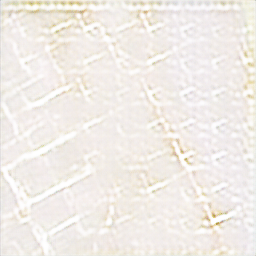

In [24]:
from IPython.display import Image, display
Image('./generated/generated-images-0001.png')

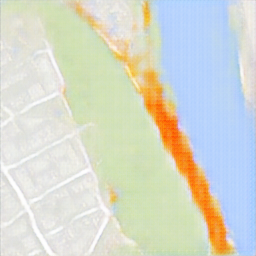

In [25]:
Image('./generated/generated-images-0005.png')

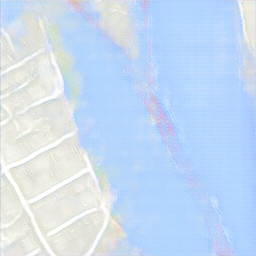

In [26]:
Image('./generated/generated-images-0010.png')

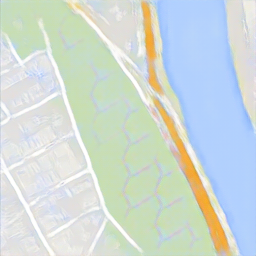

In [27]:
Image('./generated/generated-images-0050.png')

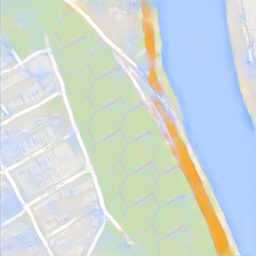

In [28]:
Image('./generated/generated-images-0100.png')

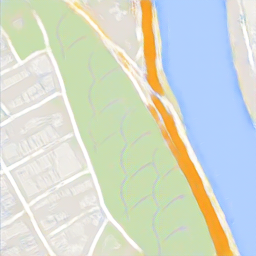

In [29]:
Image('./generated/generated-images-0150.png')

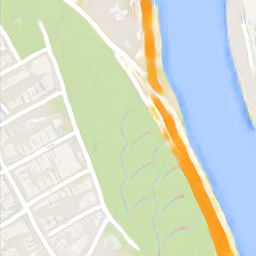

In [30]:
Image('./generated/generated-images-0200.png')

## Plotting Loss of Generator & Discriminator

In [31]:
epochs_range = list(range(1, len(losses_d) + 1))

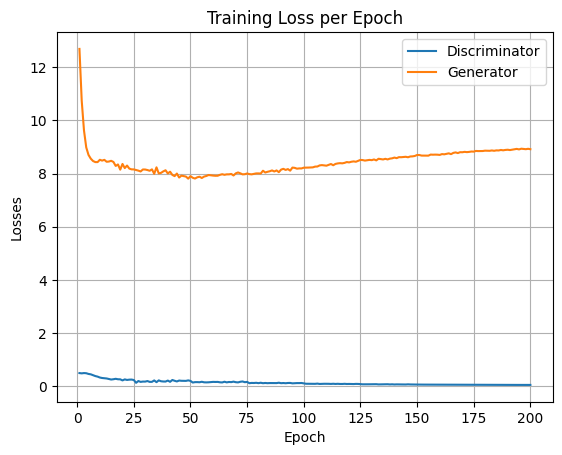

In [32]:
plt.clf()
plt.plot(epochs_range, losses_d, label="Discriminator")
plt.plot(epochs_range, losses_g, label="Generator")
plt.xlabel("Epoch")
plt.ylabel("Losses")
plt.title("Training Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

## Plotting Real & Fake Scores

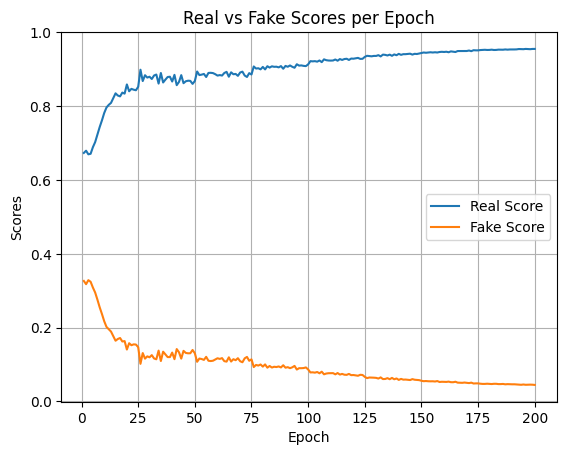

In [33]:
plt.clf()
plt.plot(epochs_range, real_scores, label="Real Score")
plt.plot(epochs_range, fake_scores, label="Fake Score")
plt.xlabel("Epoch")
plt.ylabel("Scores")
plt.title("Real vs Fake Scores per Epoch")
plt.legend()
plt.grid(True)
plt.show()

## Generating New Images

In [51]:
# Building a validation loader
val_ds   = Pix2PixDataset(data_dir, mode='val',
                          full_transform=full_transform,
                          to_tensor=to_tensor_norm)
                          
val_dl   = DataLoader(val_ds, batch_size=25, shuffle=False, num_workers=0)

In [52]:
generator = Pix2PixGenerator()
generator.load_state_dict(torch.load('G.pth'))
generator.eval()

# Sampling from val_dl
street_batch, _ = next(iter(val_dl))
fake_batch = generator(street_batch)
fake_batch = denorm(fake_batch)
real_batch = denorm(street_batch)  


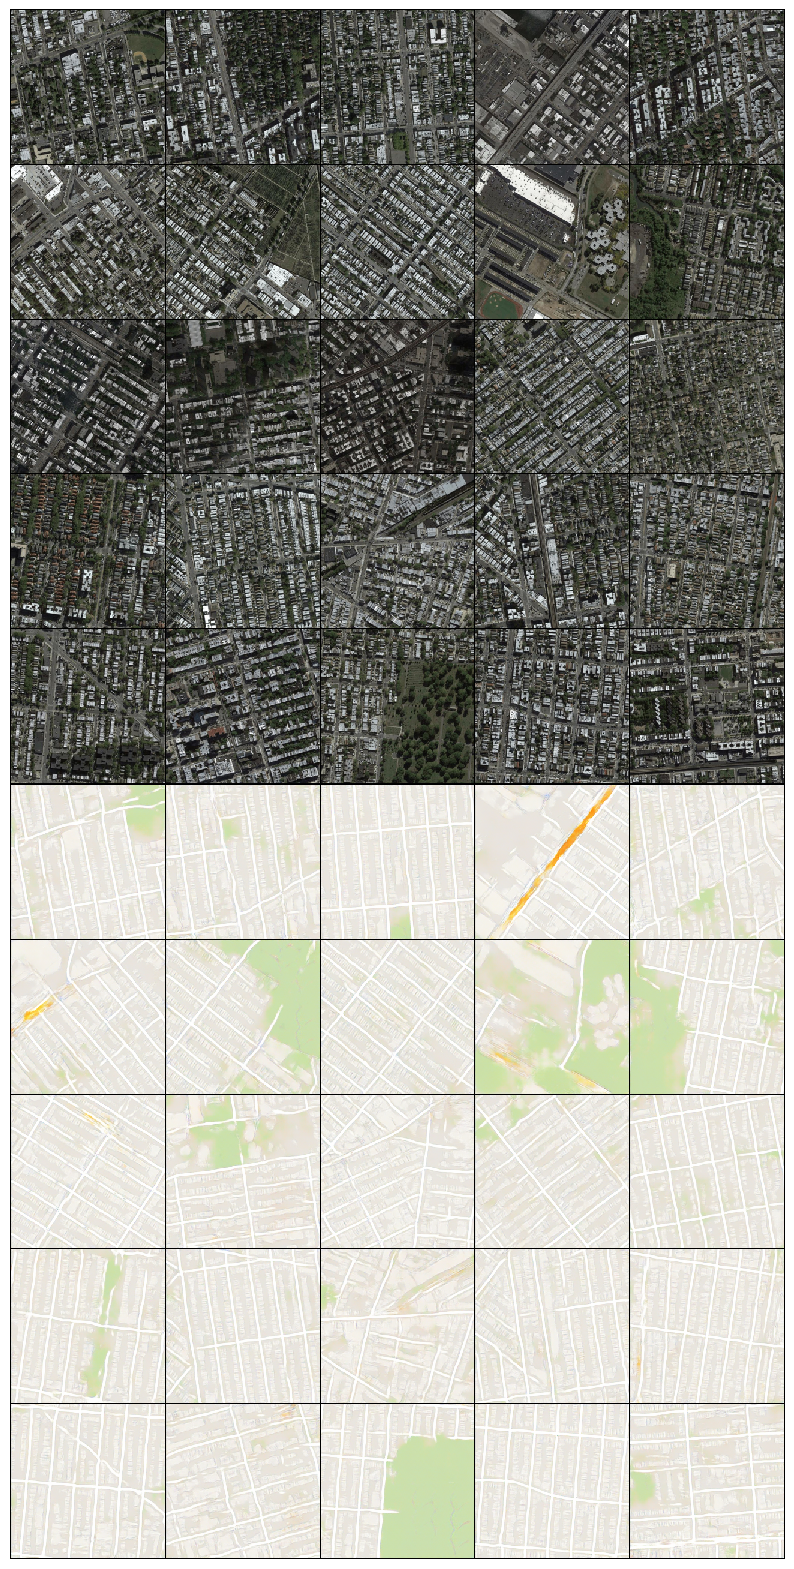

In [54]:
# Display Images
real_grid = make_grid(real_batch, nrow=5)
fake_grid = make_grid(fake_batch, nrow=5)

combined = torch.cat([real_grid, fake_grid], dim=1)

img = combined.permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(10, 25), dpi=100)
plt.axis('off')
plt.imshow(img, interpolation='nearest')
plt.show()

## User Interface

In [92]:
from torchvision.transforms import ToPILImage
import PIL

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
generator = Pix2PixGenerator().to(device)

checkpoint_path = "G.pth"
state_dict = torch.load(r'T:\checkpoint_gen_epoch200.pth', map_location=device)
generator.load_state_dict(state_dict)

generator.eval()

infer_transform = transforms.Compose([
    transforms.Resize((256, 512), interpolation=InterpolationMode.BICUBIC),
    transforms.CenterCrop((256, 512)),
])

def translate(real_img: PIL.Image.Image) -> PIL.Image.Image:
    img = infer_transform(real_img)            
    street = to_tensor_norm(img.crop((0, 0, 256, 256)))
    x = street.unsqueeze(0).to(device)
    
    with torch.no_grad():
        fake = generator(x)

    out = denorm(fake[0]).clamp(0, 1)

    return ToPILImage()(out)

In [93]:
iface = gr.Interface(
    fn=translate,
    inputs=gr.Image(type="pil", label="Street View"),
    outputs=gr.Image(type="pil", label="Generated Map"),
    title="StreetViewGAN",
    description="Upload a street view image; get the generated map."
)

In [94]:
# Launch
iface.launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.
